In [2]:
import json

file_path = "../Data/Chat_finetune.json"
with open(file_path, "r") as file:
    data = json.load(file)

In [3]:
import sys
sys.path.append('..')

In [4]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../Data/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

In [5]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

21

In [6]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Assistant'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>You 
End message: <|startoftext|>Assistant 

Validation set: 
Start message: <|startoftext|>You 
End message: <|startoftext|>Assistant 


In [7]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

In [8]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [9]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 3650
Length after: 1825

Validation data
Length before: 194
Length after: 97


In [10]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([1825, 256]), torch.Size([97, 256]))

In [11]:
train_data_tensor[0]

tensor([2492,   89,  260,   32, 2493,   32,  462,   44,   32,  104,  293,   32,
         280,  101,   32,  266,   32,  345,  279,   63, 2494, 2492,   65,  115,
         581,  304, 1167,   32, 2493,   32,  105,   39,  109,   32,  835,  101,
          46,   32,  104,  293,   32,  343,  765,   32, 1759,   63, 2494, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 24

In [12]:
val_data_tensor[0]

tensor([2492,   89,  260,   32, 2493,   32, 1864,   32,  497,  323,  116,   32,
         407,  116,   32,  363,   32, 1639,   32,  266,   32,  111,  676,   46,
        2494, 2492,   65,  115,  581,  304, 1167,   32, 2493,   32, 1864,   32,
         497,  323,  116,   32,  740,   32,  105,   39,  109,   32,  544,   46,
        2494, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496, 2496,
        2496, 2496, 2496, 2496, 2496, 24

In [14]:
train_data_tensor.shape

torch.Size([1825, 256])

In [19]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [20]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 256]), torch.Size([32, 256]))

In [21]:
from transformer.model import GPTLanguageModel

block_size = 512
n_embd = 128
n_head = 8
n_layer = 1
dropout = 0.2
batch_size = 32
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.906694 M parameters


In [22]:
checkpoint_path = "../Data/pre_training/run_1/checkpoint_2.pth"
checkpoint = torch.load(
    checkpoint_path, weights_only=True, map_location=device)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [23]:
from transformer.lora import get_lora_model, print_trainable_parameters

lora_model = get_lora_model(
    model=model,
    lora_config={
        "rank": 4,
        "alpha": 8,
    },
    device=device,
)
print_trainable_parameters(lora_model)

All parameters: 0.94M | Trainable parameters: 0.03M | Trainable %: 3.25%


In [24]:
input_tokens = tokenizer.encode("hi ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

hi renow neither do that. whe." did it happens when a puppy. n. and it's not even in heaves. then what? of it. you or two l. whiof it. he comes day. rain? for the bse of ur gookay, my launhappy together. i don't think about ittwo and say? i believe order is the score. the worse back uphere it going to be a car isn't our students to graduate. but we could <|unk|>d. hp kniell, need a t. well, you can't win if you 


In [25]:
import os
import warnings

# --- Disable Triton checks ---
os.environ["TORCHINDUCTOR_DISABLE_TRITON"] = "1"

# --- Suppress TorchDynamo / Inductor warnings ---
warnings.filterwarnings("ignore", category=UserWarning)

# Optional: fully disable TorchDynamo verbose logging
import torch._dynamo as dynamo
dynamo.reset()
dynamo.config.verbose = 0
dynamo.config.suppress_errors = True

In [26]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

In [27]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [29]:
max_iters = 10
eval_interval = 10
learning_rate = 1e-4

optimizer = torch.optim.AdamW(lora_model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=lora_model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = lora_model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=lora_model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../Data/fine_tuning/run_3/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 2.9426, val loss 3.1120
iteration 0 / step 10: train loss 2.7925, val loss 2.9760
iteration 0 / step 20: train loss 2.6900, val loss 2.8839
iteration 0 / step 30: train loss 2.6124, val loss 2.7997
iteration 0 / step 40: train loss 2.5427, val loss 2.7369
iteration 0 / step 50: train loss 2.5156, val loss 2.6986
iteration 0 / step 57: train loss 2.4887, val loss 2.6706
iteration 1 / step 0: train loss 2.4917, val loss 2.6739
iteration 1 / step 10: train loss 2.4496, val loss 2.6500
iteration 1 / step 20: train loss 2.4447, val loss 2.6201
iteration 1 / step 30: train loss 2.4078, val loss 2.5964
iteration 1 / step 40: train loss 2.3839, val loss 2.5660
iteration 1 / step 50: train loss 2.3778, val loss 2.5554
iteration 1 / step 57: train loss 2.3643, val loss 2.5702
iteration 2 / step 0: train loss 2.3961, val loss 2.6095
iteration 2 / step 10: train loss 2.3705, val loss 2.5842
iteration 2 / step 20: train loss 2.3314, val loss 2.5576
iteration 2 / ste

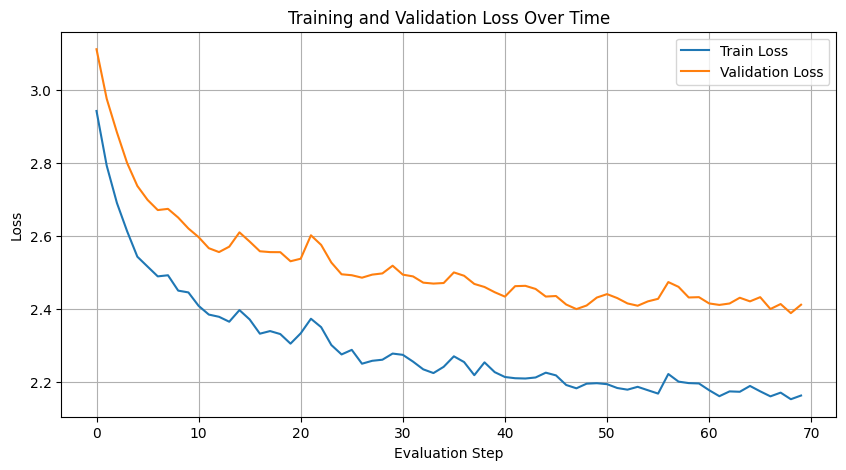

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [48]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "hi what are doing"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

lora_model.eval()
while True:
    output_tokens = lora_model.generate(
        input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: hi what are doing
Assistant:  oce ase sastant fotter taxt haved to minlltem na shou work, kid waitse
